# Import libraries

- Tensorflow: Machine Learning Library
- Matplotlib: Plotting (math) library

In [289]:
import tensorflow as tf
from matplotlib import image
from tensorflow.keras import datasets, layers, models, Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import glob
from sklearn import preprocessing

In [290]:
import warnings

#warnings.filterwarnings('ignore')

## Select Characters

Create a list of characters that we want to recognise

In [291]:
selected_characters = [
    "homer_simpson",
    "marge_simpson",
    "ned_flanders",
    "bart_simpson",
    "lisa_simpson",
    "fat_tony",
    "otto_mann",
]

encoded_labels = preprocessing.LabelEncoder()
encoded_labels.fit(selected_characters)
print(encoded_labels.transform( [
    "homer_simpson",
    "marge_simpson",
    "ned_flanders",
    "bart_simpson",
    "lisa_simpson",
    "fat_tony",
    "otto_mann",
]))
print(encoded_labels.transform(["ned_flanders"]))

[2 4 5 0 3 1 6]
[5]


## Directories

In [311]:
directories = {
    "data_directory": "./data/archive/",
}

directories["annotation_file"] = directories["data_directory"] + "annotation.txt"
directories["dataset"] = directories["data_directory"] + "simpsons_dataset/"
directories["testset"] = directories["data_directory"] + "kaggle_simpson_testset/kaggle_simpson_testset/"

## Preview all selected characters

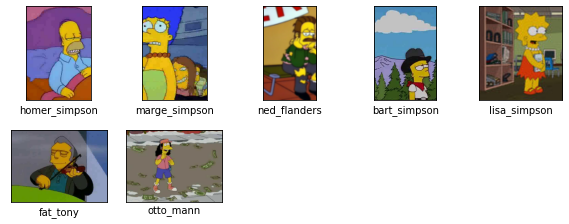

In [293]:
plt.figure(figsize=(10, 10))
i = 0
for character_name in selected_characters:
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = image.imread(directories["dataset"] + character_name + "/pic_0000.jpg")
    plt.imshow(img)
    plt.xlabel(character_name)
    i = i + 1
plt.show()

## Resize Images
For testing this code creates the same as above but resized to the standard_resolution variable

In [294]:
standard_resolution = 128
resampling_algorithm = Image.LANCZOS  # todo decide on resampling algorithm

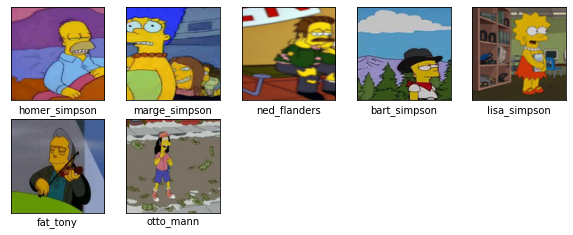

In [295]:
plt.figure(figsize=(10, 10))
i = 0
for character_name in selected_characters:
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = Image.open(directories["dataset"] + character_name + "/pic_0000.jpg")
    img = img.resize(size=(standard_resolution, standard_resolution),
                     resample=resampling_algorithm)
    img = np.asarray(img)
    plt.imshow(img)
    plt.xlabel(character_name)
    i = i + 1
plt.show()

## Load files and split into test data

In [296]:
test_factor = 0.2  # determine what percentage of each character's images should be used for testing

In [297]:
training_images = []  # the images as rgb values
training_labels = []  # the corresponding character name

test_images = []  # the test images as rgb values
test_labels = []  # the corresponding character name

for character_name in selected_characters:  #loop over all selected characters

    current_character_path = directories["dataset"] + character_name + "/"
    current_character_paths_list = glob.glob(current_character_path + "*.jpg")

    # calculate how many files are test data and how many files are training data
    current_character_picture_count = len(current_character_paths_list)
    current_character_test_count = round(current_character_picture_count * test_factor)
    current_character_training_count = round(current_character_picture_count * (1 - test_factor))
    current_image_position = 0

    encoded_character_label = encoded_labels.transform([character_name])
    print("Loading Character:" + character_name + " (label number " + str(encoded_character_label[0]) + ")")
    print("", end='\n')

    for current_image_position, current_character_picture_path in enumerate(current_character_paths_list):  #loop over all files ending in .jpg in the current folder
        print("[",current_image_position, "/", current_character_picture_count, "]" + current_character_picture_path, end='\r')


        current_character_picture = Image.open(current_character_picture_path)  # load picture
        img = current_character_picture.resize(size=(standard_resolution, standard_resolution),
                                               resample=resampling_algorithm)  # todo decide on resampling algorithm
        img = np.asarray(img)
        im = np.array(img)  #store im as numpy array
        # shape of image is ([128x(r,g,b)], [128x(r,g,b)])

        if current_image_position <= current_character_test_count:  # if the current image is still part of the test part add to testing
            test_images.append(im)
            test_labels.append(encoded_character_label)
        else:
            training_images.append(im)
            training_labels.append(encoded_character_label)
    print("", end='\n')

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)
test_images = np.array(test_images)

Loading Character:homer_simpson (label number 2)

[ 2245 / 2246 ]./data/archive/simpsons_dataset/homer_simpson/pic_2154.jpg
Loading Character:marge_simpson (label number 4)

[ 1290 / 1291 ]./data/archive/simpsons_dataset/marge_simpson/pic_0743.jpg
Loading Character:ned_flanders (label number 5)

[ 1453 / 1454 ]./data/archive/simpsons_dataset/ned_flanders/pic_0743.jpg
Loading Character:bart_simpson (label number 0)

[ 1341 / 1342 ]./data/archive/simpsons_dataset/bart_simpson/pic_0743.jpg
Loading Character:lisa_simpson (label number 3)

[ 1353 / 1354 ]./data/archive/simpsons_dataset/lisa_simpson/pic_0743.jpg
Loading Character:fat_tony (label number 1)

[ 26 / 27 ]./data/archive/simpsons_dataset/fat_tony/pic_0025.jpg
Loading Character:otto_mann (label number 6)

[ 31 / 32 ]./data/archive/simpsons_dataset/otto_mann/pic_0025.jpg


In [298]:
training_images[0].shape

(128, 128, 3)

## Create Convolutional Neuronal Network

In [299]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(standard_resolution, standard_resolution, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(selected_characters))
])

In [300]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 64)      

In [301]:
#from sklearn.preprocessing import LabelEncoder

#df[target_col] = LabelEncoder().fit_transform(df[target_col])

In [302]:
training_images, test_images = training_images / 255.0, test_images / 255.0

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # SparseCategoricalCrossentropy uses numbered labels instead of hot encoding (https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)
    metrics=['accuracy']
)

history = model.fit(
    training_images, training_labels,
    epochs=10,
    validation_data=(test_images, test_labels)
)

Epoch 1/10
194/194 [==============================] - 19s 96ms/step - loss: 1.6480 - accuracy: 0.2841 - val_loss: 1.6268 - val_accuracy: 0.2894
Epoch 2/10
194/194 [==============================] - 18s 91ms/step - loss: 1.3860 - accuracy: 0.4282 - val_loss: 1.2249 - val_accuracy: 0.5357
Epoch 3/10
194/194 [==============================] - 18s 94ms/step - loss: 1.1022 - accuracy: 0.5776 - val_loss: 1.1266 - val_accuracy: 0.5749
Epoch 4/10
194/194 [==============================] - 18s 91ms/step - loss: 1.0250 - accuracy: 0.6117 - val_loss: 1.0728 - val_accuracy: 0.6141
Epoch 5/10
194/194 [==============================] - 18s 93ms/step - loss: 0.9602 - accuracy: 0.6312 - val_loss: 1.0374 - val_accuracy: 0.6309
Epoch 6/10
194/194 [==============================] - 18s 91ms/step - loss: 0.8612 - accuracy: 0.6789 - val_loss: 1.1319 - val_accuracy: 0.5884
Epoch 7/10
194/194 [==============================] - 18s 92ms/step - loss: 0.7959 - accuracy: 0.7063 - val_loss: 0.9616 - val_accuracy:

49/49 - 1s - loss: 0.9351 - accuracy: 0.6817 - 1s/epoch - 22ms/step


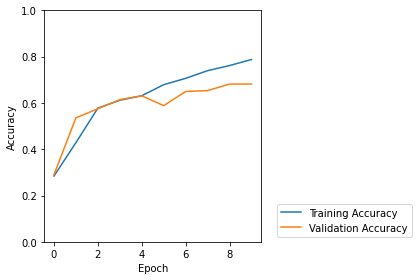

In [303]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("accuracy.png", dpi=300)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

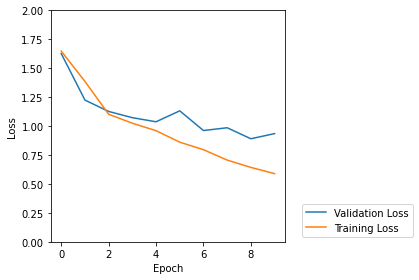

In [304]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("loss.png", dpi=300)

In [321]:
prediction_images = []

current_character_picture = Image.open(directories["testset"] + "ned_flanders_20.jpg")  # load picture
img = current_character_picture.resize(size=(standard_resolution, standard_resolution),
                                       resample=resampling_algorithm)  # todo decide on resampling algorithm
img = np.asarray(img)
im = np.array(img)

im = im / 255.0
img_array = tf.expand_dims(im, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions[0])
print(score)

#print(100 * np.max(score))

print(np.argmax(predictions))
#print([labels[i] for i,prob in enumerate(predictions) if prob > 0.5])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(encoded_labels.inverse_transform([np.argmax(score)])[0], 100 * np.max(score))
)

[ 1.5681769   0.22197266  2.6373138   1.90958    -5.122617    5.264958
 -5.8578424 ]
tf.Tensor(
[2.1786889e-02 5.6695174e-03 6.3462257e-02 3.0652419e-02 2.7065764e-05
 8.7838894e-01 1.2975253e-05], shape=(7,), dtype=float32)
5
This image most likely belongs to ned_flanders with a 87.84 percent confidence.
